In [44]:
import focusstack
import cv2
import os
from matplotlib import pyplot as plt

In [45]:
def stackHDRs(image_files, dir):
    focusimages = []
    for img in image_files:
        print("Reading in file {}".format(img))
        focusimages.append(cv2.imread(f"{dir}/{img}"))

    merged, mask = focusstack.focus_stack(focusimages)
    return merged

Reading in file step0.jpg
Reading in file step1.jpg
Reading in file step2.jpg
Reading in file step3.jpg
Reading in file step4.jpg
Reading in file step5.jpg
Detecting features of base image
Aligning image 1
Aligning image 2
Aligning image 3
Aligning image 4
Aligning image 5
Computing the laplacian of the blurred images
Lap 0
Lap 1
Lap 2
Lap 3
Lap 4
Lap 5
Shape of array of laplacians = (6, 1141, 1521)


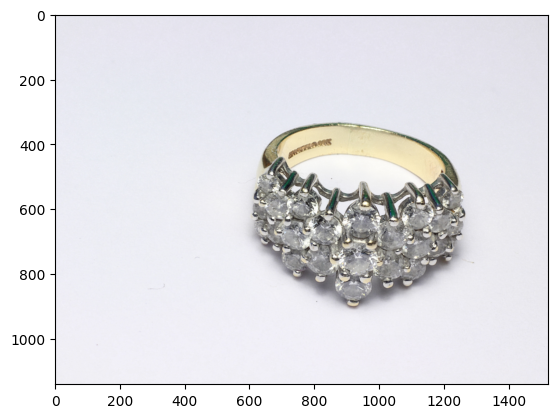

In [46]:
dir = "images/ring_sample"
image_files = sorted(os.listdir(dir))
for img in image_files:
    if img.split(".")[-1].lower() not in ["jpg", "jpeg", "png"]:
        image_files.remove(img)

merged = stackHDRs(image_files, dir)

plt.figure()
plt.imshow(merged[:,:,[2,1,0]])